# Single-Round Memory Experiments
This notebook builds short Stim circuits (e.g., `surface_code:rotated_memory_z`) to estimate how many single-round syndrome extractions a code can survive before a logical failure. Experiments are noiseless by default so that specific noise models can be dialed in later. Results from each run are appended to disk so the data can be plotted across many codes.

In [89]:
import json
import sys
import os
import importlib

from dataclasses import dataclass, field
from datetime import datetime
from pathlib import Path
from typing import Callable, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import stim
from IPython.display import display, SVG

In [ ]:
NOTEBOOK_ROOT = Path.cwd()
RESULTS_DIR = NOTEBOOK_ROOT / "memory_results"
JSON_PATH = RESULTS_DIR / "memory_survival.json"

def make_color_code_builder(*, style: str, diameter: int):
    def _builder(rounds: int = 1, noise_kwargs: Optional[Dict[str, float]] = None) -> stim.Circuit:
        effective_rounds = max(rounds, 2)
        return clorco_make_circuit(
            style=style,
            noise_model=None,
            noise_strength=0.0,
            rounds=effective_rounds,
            diameter=diameter,
            debug_out_dir=None,
            convert_to_cz=False,
            editable_extras={},
        )
    return _builder

@dataclass
class CodeSpec:
    label: str
    generator: Optional[str] = None
    generator_kwargs: Dict[str, int] = field(default_factory=dict)
    logical_qubits: int = 1
    description: str = ""
    decoder: str = "pymatching"
    builder: Optional[Callable[[int, Optional[Dict[str, float]]], stim.Circuit]] = None
    min_rounds: int = 1

    def build_circuit(
        self, rounds: int = 1, noise_kwargs: Optional[Dict[str, float]] = None
    ) -> stim.Circuit:
        effective_rounds = max(rounds, self.min_rounds)
        if self.builder is not None:
            return self.builder(rounds=effective_rounds, noise_kwargs=noise_kwargs)
        if not self.generator:
            raise ValueError(f"No generator provided for {self.label}")
        params = dict(self.generator_kwargs)
        params["rounds"] = effective_rounds
        if noise_kwargs:
            params.update(noise_kwargs)
        return stim.Circuit.generated(self.generator, **params)

def ensure_results_dir() -> None:
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)

def load_result_log() -> List[Dict[str, object]]:
    if JSON_PATH.exists():
        return json.loads(JSON_PATH.read_text())
    return []

def write_result_log(records: List[Dict[str, object]]) -> None:
    ensure_results_dir()
    JSON_PATH.write_text(json.dumps(records, indent=2))

def append_result(record: Dict[str, object]) -> None:
    records = load_result_log()
    records.append(record)
    write_result_log(records)

def write_text_summary(record: Dict[str, object]) -> Path:
    ensure_results_dir()
    path = RESULTS_DIR / f"{record['code']}_summary.txt"
    summary = [
        f"code: {record['code']}",
        f"generator: {record['generator']}",
        f"distance: {record['distance']}",
        f"rounds_per_shot: {record['rounds_per_shot']}",
        f"requested_rounds: {record['requested_rounds']}",
        f"decoder_used: {record['decoder']}",
        f"shots: {record['shots']}",
        f"logical_failures: {record['logical_failures']}",
        f"failure_rate: {record['failure_rate']:.4e}",
        f"avg_survival_rounds: {record['avg_survival_rounds']:.4f}",
        f"encoding_rate: {record['encoding_rate']:.4f}",
        f"lower_bound_only: {record['avg_survival_is_lower_bound']}",
        f"timestamp: {record['timestamp']}",
    ]
    path.write_text("\n".join(summary))
    return path

def _default_noisy_circuit(circuit: stim.Circuit) -> stim.Circuit:
    model = ns.ErrorModel(circuit)
    base_error = .002
    tau = .8e-6
    T1 = 2e-4
    lam = 1 / T1 - 1 / (2 * T1)
    p_amp = 1 - np.exp(-tau / T1)
    p_phase = 1 - np.exp(-lam * tau)
    model.setting_error('Identity', False, f'DEPOLARIZE1({base_error})')
    model.setting_error('Single_qubit', True, f'DEPOLARIZE1({base_error})')
    model.setting_error('Two_qubit', True, f'DEPOLARIZE2({base_error})')
    model.setting_error('Measurement', True, f'PAULI_CHANNEL_1({p_amp/4}, {p_amp/4}, {((1-np.sqrt((1-p_amp)*(1-p_phase)))/2)-p_amp/4})')
    model.setting_error('Reset', False, f'DEPOLARIZE1({base_error})')
    return model.generate_noisy_circuit()

def _decode_with_pymatching(circuit: stim.Circuit, shots: int) -> np.ndarray:
    det_sampler = circuit.compile_detector_sampler()
    dets, obs = det_sampler.sample(shots=shots, bit_packed=False, separate_observables=True)
    dem = circuit.detector_error_model(decompose_errors=True)
    matching = pymatching.Matching(dem)
    predictions = matching.decode_batch(dets)
    return np.any(predictions != obs, axis=1)

def _decode_with_chromobius(circuit: stim.Circuit, shots: int) -> np.ndarray:
    if not CHROMOBIUS_AVAILABLE:
        raise RuntimeError(
            "Chromobius decoder is not available. Install/build chromobius before selecting it.",
        )
    det_sampler = circuit.compile_detector_sampler()
    dets, obs = det_sampler.sample(shots=shots, bit_packed=True, separate_observables=True)
    decoder = chromobius.compile_decoder_for_dem(circuit.detector_error_model())
    predictions = decoder.predict_obs_flips_from_dets_bit_packed(dets)
    num_obs = circuit.num_observables
    obs_bits = np.unpackbits(obs, axis=1, bitorder='little')[:, :num_obs]
    pred_bits = np.unpackbits(predictions, axis=1, bitorder='little')[:, :num_obs]
    return np.any(pred_bits != obs_bits, axis=1)

def decode_logical_failures(
    circuit: stim.Circuit, shots: int, decoder: str = "pymatching"
 ) -> Tuple[np.ndarray, str]:
    if decoder == "chromobius" and not CHROMOBIUS_AVAILABLE:
        raise RuntimeError(
            "Chromobius decoder requested but not available. Install chromobius (pip install chromobius) and restart the kernel.",
        )
    noisy_circuit = _default_noisy_circuit(circuit)
    if decoder == "chromobius":
        failures = _decode_with_chromobius(noisy_circuit, shots)
    else:
        failures = _decode_with_pymatching(noisy_circuit, shots)
    return failures, decoder, noisy_circuit

def estimate_survival(shots: int, failures: int) -> Dict[str, object]:
    if failures == 0:
        return {
            "avg_survival_rounds": float(shots),
            "avg_survival_is_lower_bound": True,
        }
    return {
        "avg_survival_rounds": float(shots) / float(failures),
        "avg_survival_is_lower_bound": False,
    }

def _infer_distance(spec: CodeSpec) -> Optional[int]:
    for key in ("distance", "diameter", "base_width"):
        if key in spec.generator_kwargs:
            return spec.generator_kwargs[key]
    return None

def run_single_round_experiment(
    spec: CodeSpec,
    shots: int,
    rounds_per_shot: int = 1,
    noise_kwargs: Optional[Dict[str, float]] = None,
    notes: Optional[str] = None,
    extra_metadata: Optional[Dict[str, object]] = None,
 ) -> Dict[str, object]:
    effective_rounds = max(rounds_per_shot, spec.min_rounds)
    circuit = spec.build_circuit(rounds=effective_rounds, noise_kwargs=noise_kwargs)
    failures, decoder_used = decode_logical_failures(
        circuit, shots, decoder=spec.decoder
    )
    failure_count = int(np.count_nonzero(failures))
    survival_stats = estimate_survival(shots, failure_count)
    physical_qubits = circuit.num_qubits
    record = {
        "code": spec.label,
        "description": spec.description,
        "generator": spec.generator or "custom",
        "distance": _infer_distance(spec),
        "rounds_per_shot": effective_rounds,
        "requested_rounds": rounds_per_shot,
        "shots": shots,
        "logical_failures": failure_count,
        "failure_rate": failure_count / shots,
        "physical_qubits": physical_qubits,
        "logical_qubits": spec.logical_qubits,
        "encoding_rate": spec.logical_qubits / physical_qubits,
        "decoder": decoder_used,
        "timestamp": datetime.now().isoformat() + "Z",
        "noise_settings": noise_kwargs or {},
        "notes": notes or "noiseless",
    }
    record.update(survival_stats)
    if extra_metadata:
        record.update(extra_metadata)
    append_result(record)
    write_text_summary(record)
    return record, circuit

In [91]:
def _default_code_specs() -> Dict[str, CodeSpec]:
    base_specs = {
        "rep_d3": CodeSpec(
            label="rep_d3",
            generator="repetition_code:memory",
            generator_kwargs={"distance": 3},
            description="Distance 3 repetition code",
        ),
        "rep_d5": CodeSpec(
            label="rep_d5",
            generator="repetition_code:memory",
            generator_kwargs={"distance": 5},
            description="Distance 5 repetition code",
        ),
        "rep_d7": CodeSpec(
            label="rep_d7",
            generator="repetition_code:memory",
            generator_kwargs={"distance": 7},
            description="Distance 7 repetition code",
        ),
        "rep_d9": CodeSpec(
            label="rep_d9",
            generator="repetition_code:memory",
            generator_kwargs={"distance": 9},
            description="Distance 9 repetition code",
        ),
        "surf_rot_z_d3": CodeSpec(
            label="surf_rot_z_d3",
            generator="surface_code:rotated_memory_z",
            generator_kwargs={"distance": 3},
            description="Rotated surface code, Z memory task, distance 3.",
        ),
        "surf_rot_z_d5": CodeSpec(
            label="surf_rot_z_d5",
            generator="surface_code:rotated_memory_z",
            generator_kwargs={"distance": 5},
            description="Rotated surface code, Z memory task, distance 5.",
        ),
        "surf_rot_z_d7": CodeSpec(
            label="surf_rot_z_d7",
            generator="surface_code:rotated_memory_z",
            generator_kwargs={"distance": 7},
            description="Rotated surface code, Z memory task, distance 7.",
        ),
        "surf_rot_z_d9": CodeSpec(
            label="surf_rot_z_d9",
            generator="surface_code:rotated_memory_z",
            generator_kwargs={"distance": 9},
            description="Rotated surface code, Z memory task, distance 9.",
        ),
        "surf_unrot_z_d3": CodeSpec(
            label="surf_unrot_z_d3",
            generator="surface_code:unrotated_memory_z",
            generator_kwargs={"distance": 3},
            description="Unrotated surface code, Z memory task, distance 3.",
        ),
        "surf_unrot_z_d5": CodeSpec(
            label="surf_unrot_z_d5",
            generator="surface_code:unrotated_memory_z",
            generator_kwargs={"distance": 5},
            description="Unrotated surface code, Z memory task, distance 5.",
        ),
        "surf_unrot_z_d7": CodeSpec(
            label="surf_unrot_z_d7",
            generator="surface_code:unrotated_memory_z",
            generator_kwargs={"distance": 7},
            description="Unrotated surface code, Z memory task, distance 7.",
        ),
        "surf_unrot_z_d9": CodeSpec(
            label="surf_unrot_z_d9",
            generator="surface_code:unrotated_memory_z",
            generator_kwargs={"distance": 9},
            description="Unrotated surface code, Z memory task, distance 9.",
        ),
        "shor_mem_d3": CodeSpec(
            label="shor_mem_d3",
            generator="shor_code:memory",
            generator_kwargs={"distance": 3},
            description="Distance 3 Shor memory code.",
        ),
        "shor_mem_d5": CodeSpec(
            label="shor_mem_d5",
            generator="shor_code:memory",
            generator_kwargs={"distance": 5},
            description="Distance 5 Shor memory code.",
        ),
        "shor_mem_d7": CodeSpec(
            label="shor_mem_d7",
            generator="shor_code:memory",
            generator_kwargs={"distance": 7},
            description="Distance 7 Shor memory code.",
        ),
        "shor_mem_d9": CodeSpec(
            label="shor_mem_d9",
            generator="shor_code:memory",
            generator_kwargs={"distance": 9},
            description="Distance 9 Shor memory code.",
        ),
    }
    color_specs = {
        "color_midout_z_d3": CodeSpec(
            label="color_midout_z_d3",
            generator="chromobius:midout_color_code_Z",
            generator_kwargs={"distance": 3},
            description="Planar midout color code (Z) with base width 3.",
            decoder="chromobius",
            builder=make_color_code_builder(style="midout_color_code_Z", diameter=3),
            min_rounds=2,
        ),
        "color_midout_z_d5": CodeSpec(
            label="color_midout_z_d5",
            generator="chromobius:midout_color_code_Z",
            generator_kwargs={"distance": 5},
            description="Planar midout color code (Z) with base width 5.",
            decoder="chromobius",
            builder=make_color_code_builder(style="midout_color_code_Z", diameter=5),
            min_rounds=2,
        ),
        "color_midout_z_d7": CodeSpec(
            label="color_midout_z_d7",
            generator="chromobius:midout_color_code_Z",
            generator_kwargs={"distance": 7},
            description="Planar midout color code (Z) with base width 7.",
            decoder="chromobius",
            builder=make_color_code_builder(style="midout_color_code_Z", diameter=7),
            min_rounds=2,
        ),
        "color_midout_z_d9": CodeSpec(
            label="color_midout_z_d9",
            generator="chromobius:midout_color_code_Z",
            generator_kwargs={"distance": 9},
            description="Planar midout color code (Z) with base width 9.",
            decoder="chromobius",
            builder=make_color_code_builder(style="midout_color_code_Z", diameter=9),
            min_rounds=2,
        ),
    }
    return {**base_specs, **color_specs}

CODE_SPECS = _default_code_specs()
ACTIVE_CODES = [
    "surf_rot_z_d3",# "surf_rot_z_d5", "surf_rot_z_d7", "surf_rot_z_d9",
    # "rep_d3", "rep_d5", "rep_d7",
    # "surf_unrot_z_d3", "surf_unrot_z_d5", "surf_unrot_z_d7", "surf_unrot_z_d9",
    # "color_midout_z_d3", "color_midout_z_d5", "color_midout_z_d7", "color_midout_z_d9",
]
DEFAULT_SHOTS = 10000000
ROUNDS_PER_SHOT = 2
BASE_NOISE = {}  # add Stim noise kwargs here later (e.g., after_clifford_depolarization=0.001)

/var/folders/ch/b9nk2s4s0wd77l2b780z9wdh0000gn/T/ipykernel_74781/1916728161.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  batch_tag = datetime.utcnow().strftime("batch_%Y%m%dT%H%M%SZ")


surf_rot_z_d3: 14020 failures out of 10000000 rounds


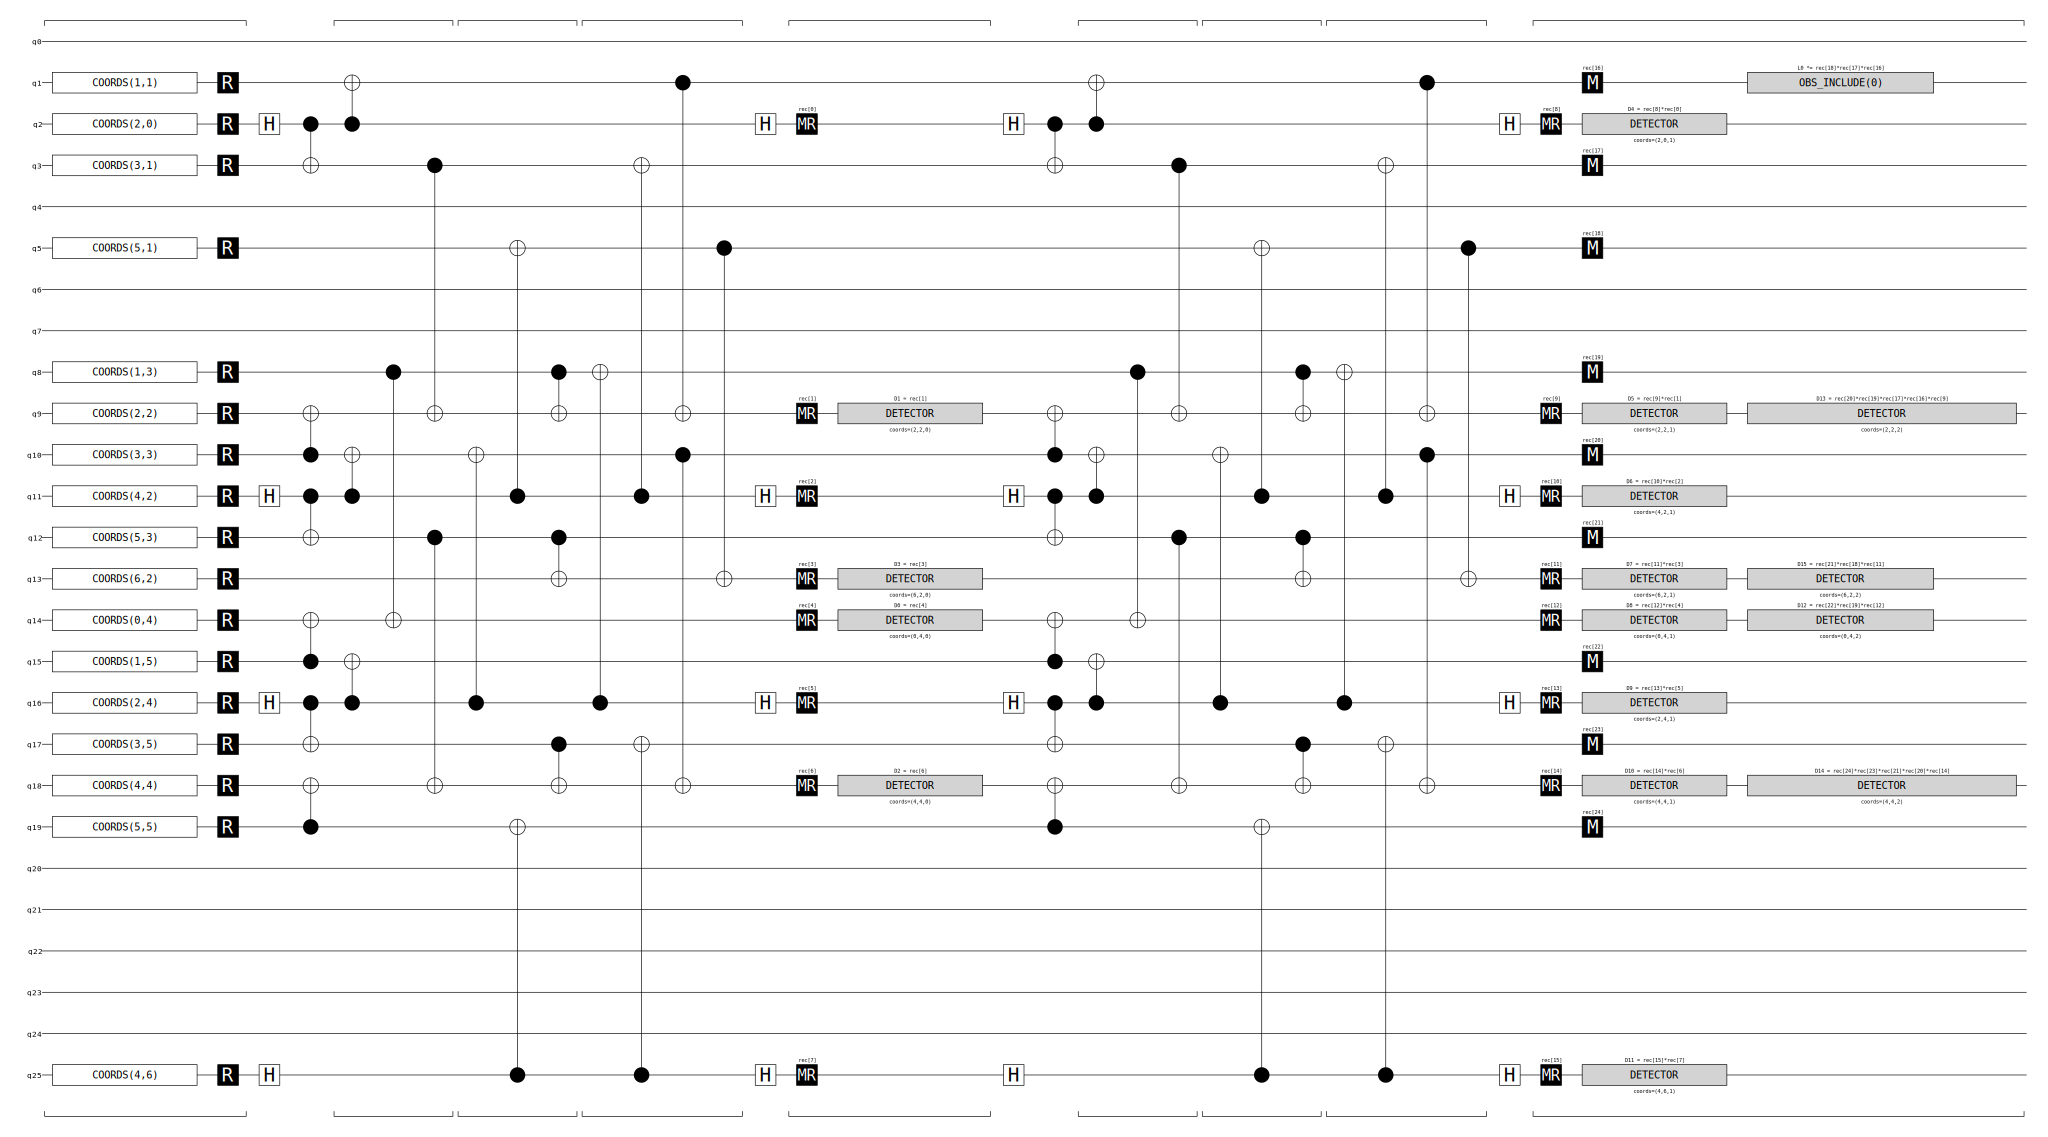

In [94]:
RUN_EXPERIMENTS = True
latest_results: List[Dict[str, object]] = []

if RUN_EXPERIMENTS:
    batch_tag = datetime.utcnow().strftime("batch_%Y%m%dT%H%M%SZ")
    for code_key in ACTIVE_CODES:
        spec = CODE_SPECS[code_key]
        result, circuit = run_single_round_experiment(
            spec,
            shots=DEFAULT_SHOTS,
            rounds_per_shot=ROUNDS_PER_SHOT,
            noise_kwargs=BASE_NOISE,
            notes="noiseless",
            extra_metadata={"batch": batch_tag},
        )
        # latest_results.append(result)
        print(f"{spec.label}: {result['logical_failures']} failures out of {DEFAULT_SHOTS} rounds")
        
else:
    print("Set RUN_EXPERIMENTS = True and re-run this cell to collect data.")

circuit.diagram('timeline-svg')

,code,encoding_rate,distance,shots,logical_failures,failure_rate,avg_survival_rounds,avg_survival_is_lower_bound,batch,notes
9,surf_unrot_z_d9,0.003460,9,10000000,13,0.000001,769230.769231,False,batch_20251201T004012Z,noiseless
3,surf_rot_z_d9,0.005319,9,10000000,43,0.000004,232558.139535,False,batch_20251201T004012Z,noiseless
8,surf_unrot_z_d7,0.005917,7,10000000,199,0.000020,50251.256281,False,batch_20251201T004012Z,noiseless
2,surf_rot_z_d7,0.008475,7,10000000,299,0.000030,33444.816054,False,batch_20251201T004012Z,noiseless
7,surf_unrot_z_d5,0.012346,5,10000000,2186,0.000219,4574.565416,False,batch_20251201T004012Z,noiseless
13,color_midout_z_d9,0.014493,9,10000000,1305,0.000131,7662.835249,False,batch_20251201T004012Z,noiseless
1,surf_rot_z_d5,0.015625,5,10000000,2362,0.000236,4233.700254,False,batch_20251201T004012Z,noiseless
12,color_midout_z_d7,0.023256,7,10000000,6249,0.000625,1600.256041,False,batch_20251201T004012Z,noiseless
0,surf_rot_z_d3,0.038462,3,10000000,14231,0.001423,702.691308,False,batch_20251201T004012Z,noiseless
6,surf_unrot_z_d3,0.040000,3,10000000,20491,0.002049,488.019130,False,batch_20251201T004012Z,noiseless


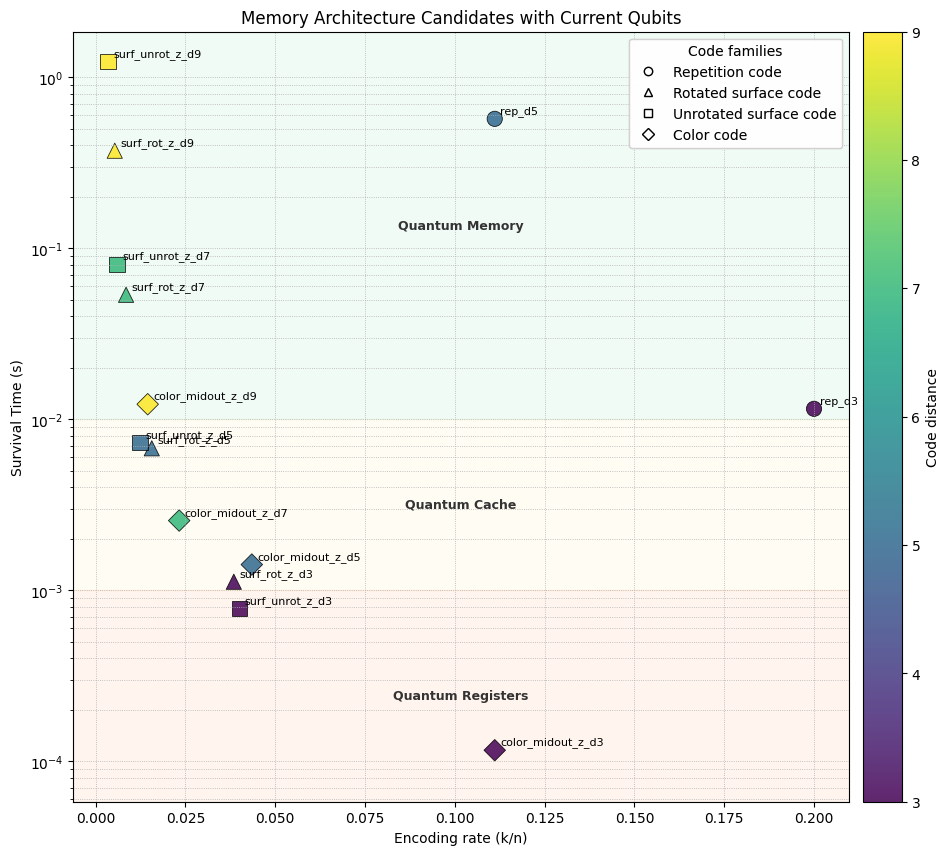

In [ ]:
records = load_result_log()
if not records:
    print("No experiment data found yet. Run the previous cell first.")
else:
    df = pd.DataFrame(records)
    df = df.sort_values(["encoding_rate", "timestamp"])
    df = df.copy()
    survival_time = df["avg_survival_rounds"] * 2 * 0.8e-6
    display_columns = [
        "code","encoding_rate","distance","shots","logical_failures",
        "failure_rate","avg_survival_rounds","avg_survival_is_lower_bound","batch","notes"
    ]
    available_cols = [c for c in display_columns if c in df.columns]
    display(df[available_cols].tail(len(df)))

    def classify_code(label: str) -> str:
        if label.startswith("rep_"):
            return "Repetition code"
        if label.startswith("surf_rot"):
            return "Rotated surface code"
        if label.startswith("surf_unrot"):
            return "Unrotated surface code"
        if label.startswith("shor_"):
            return "Shor code"
        if label.startswith("color_"):
            return "Color code"
        return "Other"

    df["code_type"] = df["code"].apply(classify_code)
    distance_values = df.get("distance")
    if distance_values is None or distance_values.isnull().all():
        distance_values = pd.Series(np.zeros(len(df)), index=df.index)
    else:
        distance_values = distance_values.fillna(distance_values.min())

    cmap = plt.get_cmap("viridis")
    norm = plt.Normalize(distance_values.min(), distance_values.max() if distance_values.max() > distance_values.min() else distance_values.min() + 1)

    fig, ax = plt.subplots(figsize=(12, 10))

    marker_map = {
        "Repetition code": "o",
        "Rotated surface code": "^",
        "Unrotated surface code": "s",
        "Shor code": "P",
        "Color code": "D",
        "Other": "x",
    }
    scatter_handles = []
    color_mappable = None

    for code_type, marker in marker_map.items():
        subset = df[df["code_type"] == code_type]
        if subset.empty:
            continue
        color_mappable = ax.scatter(
            subset["encoding_rate"],
            survival_time.loc[subset.index],
            c=distance_values.loc[subset.index],
            cmap=cmap,
            norm=norm,
            marker=marker,
            s=120,
            edgecolor="k",
            alpha=0.85,
            linewidth=0.6,
        )
        scatter_handles.append(
            Line2D([], [], marker=marker, linestyle="", color="k", markerfacecolor="w", label=code_type)
        )

    ax.set_xlabel("Encoding rate (k/n)")
    ax.set_ylabel("Survival Time (s)")
    ax.set_yscale("log")
    ax.set_title("Memory Architecture Candidates with Current Qubits")

    lower_bound = max(1e-6, float(survival_time.min()) * 0.5)
    upper_bound = max(1e-1, float(survival_time.max()) * 1.5)
    ax.set_ylim(lower_bound, upper_bound)

    region_specs = [
        {"low": 1e-2, "high": None, "label": "Quantum Memory", "color": "#a5e5be"},
        {"low": 1e-3, "high": 1e-2, "label": "Quantum Cache", "color": "#ffefb0"},
        {"low": 0, "high": 1e-3, "label": "Quantum Registers", "color": "#ffbb8d"},
    ]
    ymin, ymax = ax.get_ylim()
    for region in region_specs:
        low = max(region["low"], ymin)
        high = region["high"] if region["high"] is not None else ymax
        high = min(high, ymax)
        if high <= low:
            continue
        ax.axhspan(low, high, color=region["color"], alpha=0.15, zorder=0)
        label_y = np.sqrt(low * high)
        ax.text(
            .5,
            label_y,
            region["label"],
            color="#333333",
            fontsize=9,
            weight="bold",
            va="center",
            ha="center",
            transform=ax.get_yaxis_transform(),
            zorder=5,
        )

    for _, row in df.iterrows():
        ax.annotate(
            row["code"],
            (row["encoding_rate"], survival_time.loc[row.name]),
            fontsize=8,
            xytext=(4, 4),
            textcoords="offset points"
        )

    if scatter_handles:
        shape_legend = ax.legend(handles=scatter_handles, title="Code families", loc="upper right")
        ax.add_artist(shape_legend)

    if color_mappable is not None:
        cbar = fig.colorbar(color_mappable, ax=ax, pad=0.015)
        cbar.set_label("Code distance")

    ax.grid(True, which="both", ls=":", lw=0.6)
    plt.show()

### Notes
- Each run samples `shots` single-round circuits per code, decodes the resulting syndromes with MWPM or Chromobius (for color codes), and records how many logical observables disagree with the decoder predictions. Color-code specs always use Chromobius and now raise an error if the decoder is unavailable instead of silently falling back.
- Unrotated surface-code memories (`surf_unrot_z_*`) now sit alongside the rotated variants so you can compare layout choices without editing any other part of the workflow.
- Shor code memories (`shor_mem_d*`) are included as another cat-code baseline; they share the same MWPM decoding path so you can pit them directly against repetition and surface codes.
- After every experiment the Stim circuit diagram is dumped to `memory_results/circuit_diagrams/` via `circuit.diagram('timeline-svg')` and rendered inline so you get a persistent visual trace of the circuit that actually ran.
- Data are written to `memory_results/memory_survival.json` (append-only log) plus a per-code text snapshot so you can track changes or move data into another plotting script.
- To inject noise, populate `BASE_NOISE` with any keyword arguments accepted by `stim.Circuit.generated` (e.g., `after_clifford_depolarization=5e-4`, `after_reset_flip_probability=1e-3`).
- Add or remove codes by editing `CODE_SPECS` / `ACTIVE_CODES`. Anything Stim exposes via `stim.Circuit.generated` can be dropped in as long as it has at least one logical observable.
- Chromobius-powered color-code entries (`color_midout_z_*`) are constructed via `clorco` helpers so they stay in sync with the latest layouts while automatically logging into the shared results file. These circuits require at least two syndrome rounds, so the run log now captures both the requested and actual round counts.
- The plotting cell expects average survival data per code. When no failures are observed the reported survival is a lower bound (equal to the number of rounds that were simulated).